In [1]:
import re
import pandas as pd
import nltk
import numpy as np
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

!pip install datasketch

import time
from datasketch import MinHashLSH, MinHash
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import time


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

# Text Preprocess

In [2]:
regex_pattern = re.compile(r'[^a-zA-Z0-9\s]')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = regex_pattern.sub('', text)
    text = text.lower()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(lemmatized_tokens)

In [3]:
df = pd.read_csv('../input/bigdata2023classification/train.csv', delimiter=',', nrows = 100)
df['Content'] = df['Content'].apply(preprocess_text)
X = df['Content']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorization

In [4]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Jaccard Similarity

In [5]:
def jaccard_similarity(doc1, doc2):
    # sparse to sets of indices for intersection and union
    indices1 = set(doc1.indices)
    indices2 = set(doc2.indices)
    
    intersection = len(indices1.intersection(indices2))
    union = len(indices1.union(indices2))
    return intersection / union if union != 0 else 0

# MinHash Document

In [6]:
# MinHash signature from vectorized documents
def minhash_document(vectorized_doc, num_perm):
    minhash = MinHash(num_perm=num_perm)
    for idx in vectorized_doc.indices:
        minhash.update(str(idx).encode('utf8'))
    return minhash

# Build LSH Index

In [7]:
# Build LSH index from vectorized documents 
def build_lsh_index(X_train_vec, num_perm, threshold):
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    for idx, doc in enumerate(X_train_vec):
        minhash = minhash_document(doc, num_perm=num_perm)
        lsh.insert(idx, minhash)
    return lsh

# Finding NN using LSH

In [8]:
def find_nearest_neighbors_lsh(X_test_vec, lsh, num_perm):
    neighbors = []
    for doc in X_test_vec:
        minhash = minhash_document(doc, num_perm=num_perm)
        result = lsh.query(minhash)
        neighbors.append(result)
    return neighbors


# Brute-Force KNN

In [9]:
kneighbors_jaccard = KNeighborsClassifier(n_neighbors=15, algorithm='brute', metric=jaccard_similarity, n_jobs=-1)
kneighbors_jaccard.fit(X_train_vec, y_train)

# Brute-Force KNN for a test instance
start = time.time()
k_neighbors = kneighbors_jaccard.kneighbors(X_test_vec[1], return_distance=False)
end = time.time()
print("Brute-force KNN time:", end - start)
print("Brute-force KNN neighbors:", k_neighbors)

Brute-force KNN time: 0.06252026557922363
Brute-force KNN neighbors: [[ 2 25 44 74 33 28 10 37 69 15 31 32 79 72 12]]


# Evaluation of LSH

In [10]:
# Comparing LSH performance with brute-force KNN

K = 15  # Number of nearest neighbors
threshold = 0.8  # LSH similarity threshold
num_permutations = [16, 32, 64] # Number of permutations for LSH

# Precompute brute-force KNN similarities
start_bruteforce_query_time = time.time()
true_similarities_brute_force = []
for i, test_doc in enumerate(X_test_vec):
    true_neighbours = kneighbors_jaccard.kneighbors(test_doc, return_distance=False)[0][:K]
    true_similarities_brute_force.append(set(true_neighbours))
end_bruteforce_query_time = time.time()
bruteforce_query_time = end_bruteforce_query_time - start_bruteforce_query_time
print ("Bruteforce_Query_Time:", bruteforce_query_time)

evaluation_results_batch = []

for num_perm in num_permutations:
    # LSH index creation
    start_build_time = time.time()
    lsh_index = build_lsh_index(X_train_vec, num_perm, threshold)
    end_build_time = time.time()
    build_time = end_build_time - start_build_time

    # Query LSH index for nearest neighbors of test documents
    start_query_time = time.time()
    lsh_results = find_nearest_neighbors_lsh(X_test_vec, lsh_index, num_perm)
    end_query_time = time.time()
    query_time = end_query_time - start_query_time

    total_time = build_time + query_time

    # Fraction of true K most similar documents found by LSH
    fraction_correct_lsh = []
    for true, lsh_neighbors in zip(true_similarities_brute_force, lsh_results):
        correct_identifications = len(true.intersection(lsh_neighbors))
        fraction_correct = correct_identifications / K
        fraction_correct_lsh.append(fraction_correct)

    evaluation_results_batch.append({
        "Num_Permutations": num_perm,
        "LSH_Index_Creation_Time": build_time,
        "Query_Time": query_time,
        "Total_Time": total_time,
        "Fraction_of_True_K_Most_Similar_Documents_LSH": np.mean(fraction_correct_lsh)
    })
    print("LSH Results:", lsh_results[:5])
    print("True Similarities:", true_similarities_brute_force[:5])

for result in evaluation_results_batch:
    print(result)

Bruteforce_Query_Time: 0.8688654899597168
LSH Results: [[], [], [], [], []]
True Similarities: [{33, 2, 1, 39, 41, 10, 75, 28, 14, 77, 79, 57, 60, 30, 31}, {32, 33, 2, 37, 69, 72, 74, 10, 44, 12, 15, 79, 25, 28, 31}, {33, 2, 36, 72, 9, 12, 13, 78, 79, 14, 17, 44, 21, 58, 28}, {64, 67, 4, 39, 74, 10, 12, 13, 44, 79, 14, 48, 17, 25, 30}, {2, 3, 37, 69, 39, 74, 43, 12, 14, 48, 19, 25, 58, 28, 30}]
LSH Results: [[], [], [], [], []]
True Similarities: [{33, 2, 1, 39, 41, 10, 75, 28, 14, 77, 79, 57, 60, 30, 31}, {32, 33, 2, 37, 69, 72, 74, 10, 44, 12, 15, 79, 25, 28, 31}, {33, 2, 36, 72, 9, 12, 13, 78, 79, 14, 17, 44, 21, 58, 28}, {64, 67, 4, 39, 74, 10, 12, 13, 44, 79, 14, 48, 17, 25, 30}, {2, 3, 37, 69, 39, 74, 43, 12, 14, 48, 19, 25, 58, 28, 30}]
LSH Results: [[], [], [], [], []]
True Similarities: [{33, 2, 1, 39, 41, 10, 75, 28, 14, 77, 79, 57, 60, 30, 31}, {32, 33, 2, 37, 69, 72, 74, 10, 44, 12, 15, 79, 25, 28, 31}, {33, 2, 36, 72, 9, 12, 13, 78, 79, 14, 17, 44, 21, 58, 28}, {64, 67, 4,

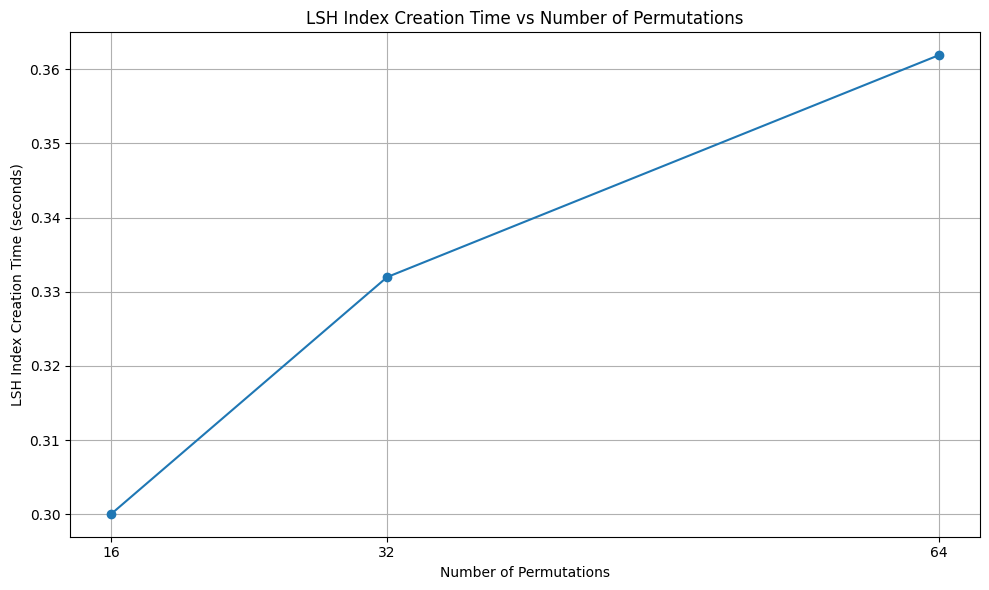

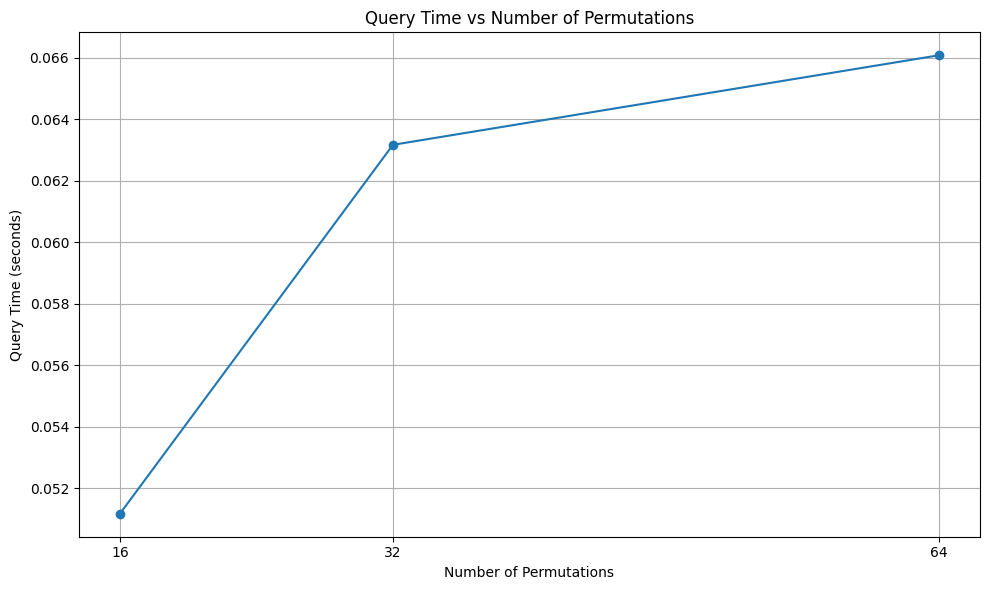

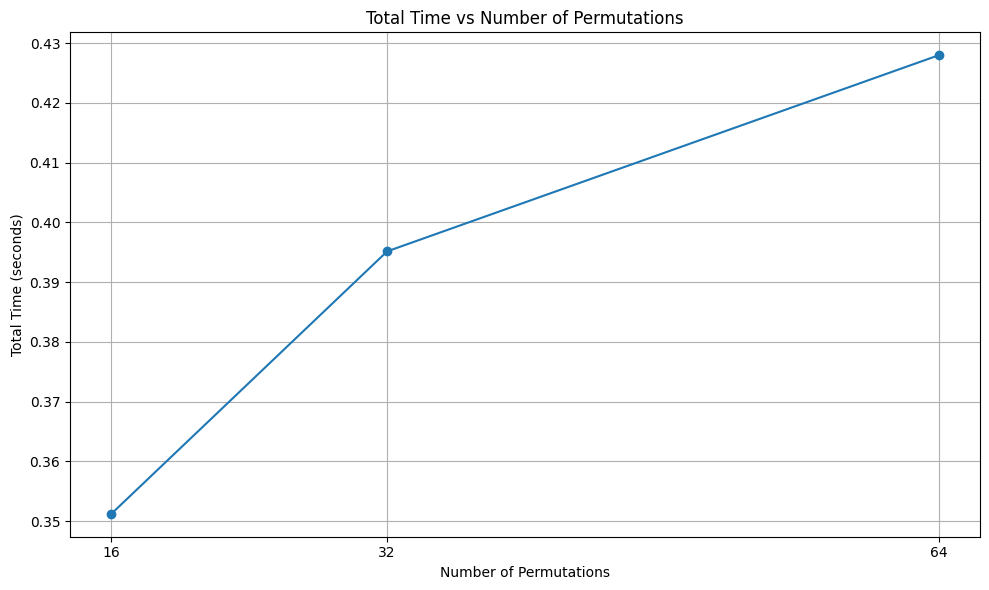

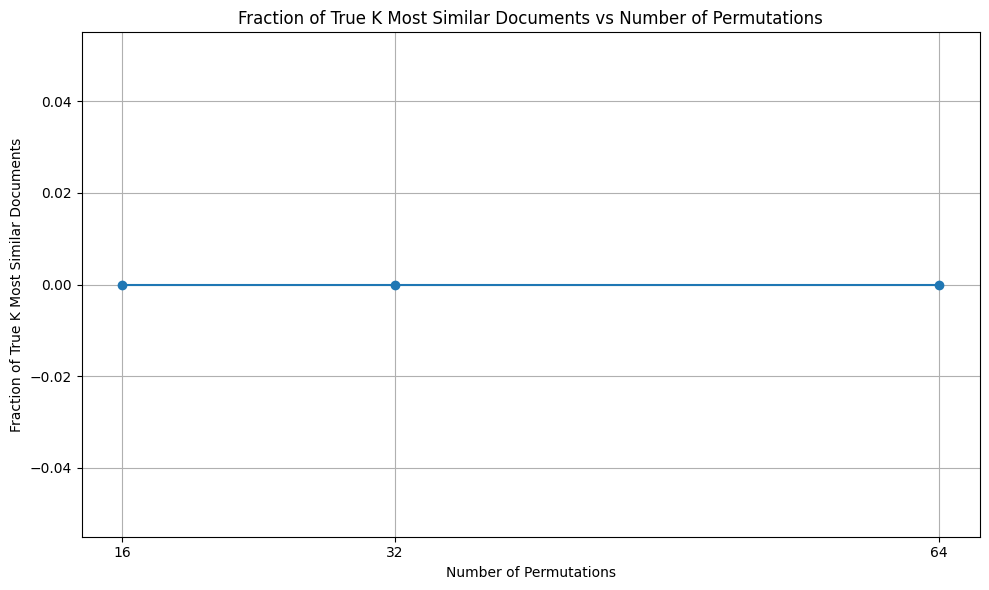

In [11]:
num_permutations = [result["Num_Permutations"] for result in evaluation_results_batch]
build_times = [result["LSH_Index_Creation_Time"] for result in evaluation_results_batch]
query_times = [result["Query_Time"] for result in evaluation_results_batch]
total_times = [result["Total_Time"] for result in evaluation_results_batch]
fraction_correct = [result["Fraction_of_True_K_Most_Similar_Documents_LSH"] for result in evaluation_results_batch]

# Creation time
plt.figure(figsize=(10, 6))
plt.plot(num_permutations, build_times, marker='o', linestyle='-')
plt.title('LSH Index Creation Time vs Number of Permutations')
plt.xlabel('Number of Permutations')
plt.ylabel('LSH Index Creation Time (seconds)')
plt.grid(True)
plt.xticks(num_permutations)
plt.tight_layout()
plt.show()

# Query time
plt.figure(figsize=(10, 6))
plt.plot(num_permutations, query_times, marker='o', linestyle='-')
plt.title('Query Time vs Number of Permutations')
plt.xlabel('Number of Permutations')
plt.ylabel('Query Time (seconds)')
plt.grid(True)
plt.xticks(num_permutations)
plt.tight_layout()
plt.show()

# Total time
plt.figure(figsize=(10, 6))
plt.plot(num_permutations, total_times, marker='o', linestyle='-')
plt.title('Total Time vs Number of Permutations')
plt.xlabel('Number of Permutations')
plt.ylabel('Total Time (seconds)')
plt.grid(True)
plt.xticks(num_permutations)
plt.tight_layout()
plt.show()

# Fraction of true K most similar
plt.figure(figsize=(10, 6))
plt.plot(num_permutations, fraction_correct, marker='o', linestyle='-')
plt.title('Fraction of True K Most Similar Documents vs Number of Permutations')
plt.xlabel('Number of Permutations')
plt.ylabel('Fraction of True K Most Similar Documents')
plt.grid(True)
plt.xticks(num_permutations)
plt.tight_layout()
plt.show()